In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import os
import numpy as np
from torch.nn import init
import functools
import random
import matplotlib.pyplot as plt

In [11]:
from torchvision import transforms

class FacadesDataset(Dataset):
    def __init__(self, root_dir, split='train'):
        self.root_dir = root_dir
        self.split = split
        self.image_dir = os.path.join(root_dir, f'{split}B')
        self.label_dir = os.path.join(root_dir, f'{split}A')
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.jpg')])
        self.label_files = sorted([f for f in os.listdir(self.label_dir) if f.endswith('.jpg')])
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),  
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        
        # Load images
        image = Image.open(image_path).convert('RGB')
        label = Image.open(label_path).convert('RGB')
        
        # Apply transformations
        image = self.transform(image)
        label = self.transform(label)
        
        return {'image': image, 'label': label}



In [12]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, dropout=0.5):
        super(ResnetBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.Dropout(dropout),  # Ajout du dropout
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        out = x + self.conv_block(x)
        return out


In [13]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=6):  # Réduit de 9 à 6 blocks
        super(Generator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        
        # Enregistrer la moyenne mobile
        self.register_buffer('running_mean', torch.zeros(1))
        self.momentum = 0.99

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True)
        ]

        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(ngf * mult * 2),
                nn.ReLU(True)
            ]

        # Resnet blocks
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult)]

        # Upsampling
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3,
                               stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        output = self.model(input)
        # Appliquer la moyenne mobile
        with torch.no_grad():
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * output
        return output

In [14]:
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=32, n_layers=2):  # Réduit ndf à 32 et n_layers à 2
        super(NLayerDiscriminator, self).__init__()
        
        kw = 4
        padw = 2  # Augmenté de 1 à 2
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                         kernel_size=kw, stride=2, padding=padw),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                     kernel_size=kw, stride=1, padding=padw),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)

In [15]:
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(1.0))
        self.register_buffer('fake_label', torch.tensor(0.0))
        self.loss = nn.MSELoss() if use_lsgan else nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        target_tensor = self.real_label if target_is_real else self.fake_label
        return target_tensor.expand_as(input)

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)


In [16]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [17]:

def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transform pour le dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Chargement des données
dataset = FacadesDataset(root_dir='/home/yasminehabchi/Downloads/AI', split='train')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

# Initialisation des réseaux
netG = Generator(input_nc=3, output_nc=3).to(device)
netD = NLayerDiscriminator(input_nc=6).to(device)

# Initialisation des poids
init_weights(netG)
init_weights(netD)

# Définition des fonctions de perte
criterionGAN = GANLoss().to(device)
criterionL1 = nn.L1Loss()

# Optimizers avec learning rates différents
optimizer_G = torch.optim.Adam(netG.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Learning rate schedulers
scheduler_G = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=200, eta_min=1e-5)
scheduler_D = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_D, T_max=200, eta_min=1e-5)

# Listes pour stocker les pertes
D_losses = []
G_losses = []

In [19]:
num_epochs = 50
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        real_B = data['image'].to(device)
        real_A = data['label'].to(device)
        
        # Mise à jour du Discriminateur
        optimizer_D.zero_grad()
        
        # Générer une image fake
        fake_A = netG(real_B)
        
        # Préparer les entrées pour le discriminateur
        fake_BA = torch.cat((real_B, fake_A), 1)
        real_BA = torch.cat((real_B, real_A), 1)
        
        # Calculer les pertes pour les images fake
        pred_fake = netD(fake_BA.detach())
        loss_D_fake = criterionGAN(pred_fake, False)
        
        # Calculer les pertes pour les images réelles
        pred_real = netD(real_BA)
        loss_D_real = criterionGAN(pred_real, True)
        
        # Gradient penalty
        gp = gradient_penalty(netD, real_BA, fake_BA.detach())
        
        # Combiner les pertes du discriminateur et rétropropager
        loss_D = (loss_D_fake + loss_D_real) * 0.5 + 10.0 * gp
        loss_D.backward()
        optimizer_D.step()
        
        # Mise à jour du Générateur
        optimizer_G.zero_grad()
        
        # Recalculer pred_fake pour la perte du générateur
        fake_BA = torch.cat((real_B, fake_A), 1)
        pred_fake = netD(fake_BA)
        
        # Calculer les pertes du générateur
        loss_G_GAN = criterionGAN(pred_fake, True)
        loss_G_L1 = criterionL1(fake_A, real_A) * 50.0  # Réduit de 100 à 50
        loss_G = loss_G_GAN + loss_G_L1
        loss_G.backward()
        optimizer_G.step()
        
        # Stocker les pertes
        D_losses.append(loss_D.item())
        G_losses.append(loss_G.item())
        
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], '
                  f'D_loss: {loss_D.item():.4f}, G_loss: {loss_G.item():.4f}, '
                  f'GAN_loss: {loss_G_GAN.item():.4f}, L1_loss: {loss_G_L1.item():.4f}')
    
    # Mettre à jour les learning rates
    scheduler_G.step()
    scheduler_D.step()

Epoch [1/50], Step [0/400], D_loss: 18912.4980, G_loss: 30.8896, GAN_loss: 1.6489, L1_loss: 29.2407
Epoch [1/50], Step [100/400], D_loss: 76.8532, G_loss: 16.6139, GAN_loss: 1.1396, L1_loss: 15.4743
Epoch [1/50], Step [200/400], D_loss: 9.3520, G_loss: 20.6815, GAN_loss: 1.0461, L1_loss: 19.6354
Epoch [1/50], Step [300/400], D_loss: 4.6364, G_loss: 18.5390, GAN_loss: 0.9524, L1_loss: 17.5866
Epoch [2/50], Step [0/400], D_loss: 0.5390, G_loss: 26.2007, GAN_loss: 0.9115, L1_loss: 25.2892
Epoch [2/50], Step [100/400], D_loss: 0.8376, G_loss: 14.7426, GAN_loss: 0.8795, L1_loss: 13.8631
Epoch [2/50], Step [200/400], D_loss: 1.5321, G_loss: 19.6980, GAN_loss: 0.8383, L1_loss: 18.8596
Epoch [2/50], Step [300/400], D_loss: 0.5851, G_loss: 21.8332, GAN_loss: 0.8078, L1_loss: 21.0254
Epoch [3/50], Step [0/400], D_loss: 0.9948, G_loss: 23.1296, GAN_loss: 0.7888, L1_loss: 22.3408
Epoch [3/50], Step [100/400], D_loss: 0.4364, G_loss: 14.8970, GAN_loss: 0.7721, L1_loss: 14.1248
Epoch [3/50], Step [2

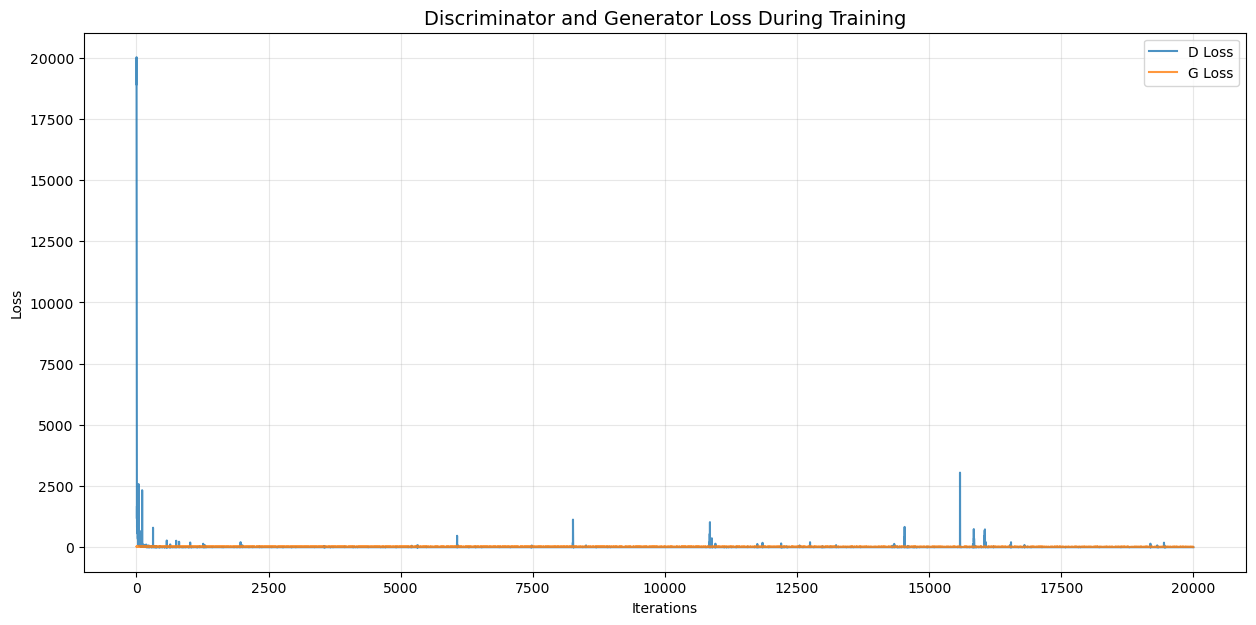

In [20]:
# Tracé des courbes de perte
import matplotlib.pyplot as plt

D_losses_cpu = [loss if isinstance(loss, float) else loss.cpu().item() for loss in D_losses]
G_losses_cpu = [loss if isinstance(loss, float) else loss.cpu().item() for loss in G_losses]

plt.figure(figsize=(15, 7))
plt.title("Discriminator and Generator Loss During Training", fontsize=14)
plt.plot(D_losses_cpu, label="D Loss", alpha=0.8)
plt.plot(G_losses_cpu, label="G Loss", alpha=0.8)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

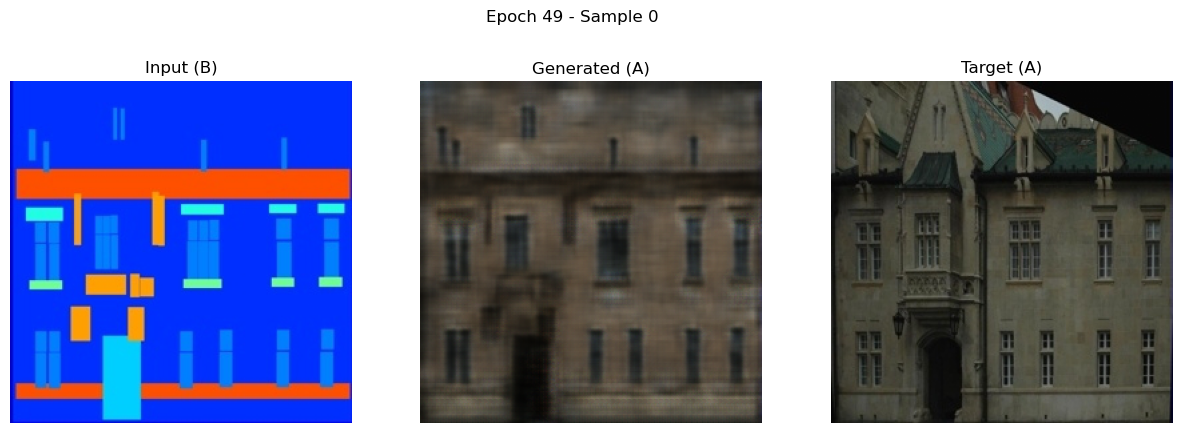

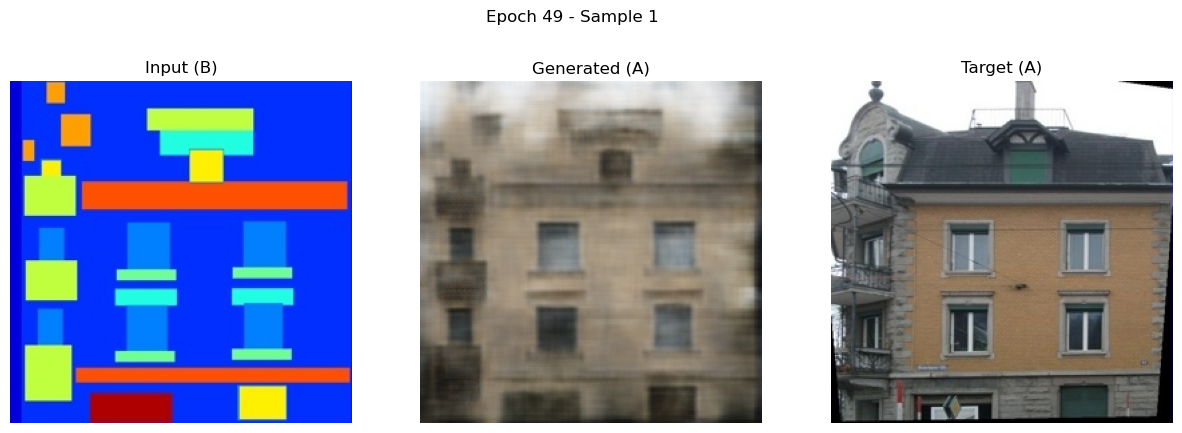

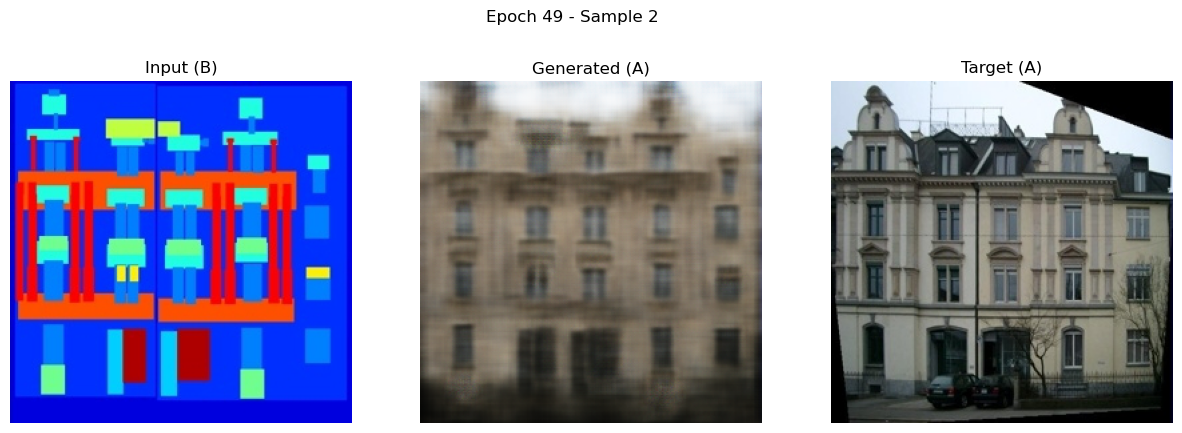

In [21]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os

def save_and_show_images(epoch, real_B, fake_A, real_A, sample_idx):
    save_dir = '/home/yasminehabchi/Downloads/AI/'
    os.makedirs(save_dir, exist_ok=True)
    
    images = torch.cat([real_B, fake_A, real_A], 0)
    save_path = os.path.join(save_dir, f'epoch_{epoch}_sample_{sample_idx}.png')
    torchvision.utils.save_image(images, save_path, normalize=True)
    
    def tensor_to_numpy(img):
        if img.is_cuda:
            img = img.cpu()
        img = img.detach().numpy()
        img = img.transpose(0, 2, 3, 1)
        if img.min() < 0:
            img = (img + 1) / 2
        return img.clip(0, 1)
    
    real_B_np = tensor_to_numpy(real_B)
    fake_A_np = tensor_to_numpy(fake_A)
    real_A_np = tensor_to_numpy(real_A)
    
    # Display the images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(real_B_np[0])
    axes[0].set_title('Input (B)')
    axes[0].axis('off')
    
    axes[1].imshow(fake_A_np[0])
    axes[1].set_title('Generated (A)')
    axes[1].axis('off')
    
    axes[2].imshow(real_A_np[0])
    axes[2].set_title('Target (A)')
    axes[2].axis('off')
    
    plt.suptitle(f'Epoch {epoch} - Sample {sample_idx}')
    plt.show()
    plt.close()

# Generate and display 3 samples
with torch.no_grad():
    for sample_idx, sample_data in enumerate(dataloader):
        real_B = sample_data['image'].to(device)  # Ground truth (input)
        real_A = sample_data['label'].to(device)  # Target
        fake_A = netG(real_B)  # Generated output
        
        save_and_show_images(epoch, real_B, fake_A, real_A, sample_idx)
        
        if sample_idx == 2:  
            break
